In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import config

print(config.ROOT_FOLDER)

/Users/alexander.prams/autotune


In [2]:
with open(os.path.join(config.ROOT_FOLDER, 'experiment_results/hpo_dataset_optimizer_results.pickle'), 'rb') as handle:
    optimizer_results = pickle.load(handle)

In [3]:
# Optimizer results dict has structure [optimizer.name][classifier_name][dataset_idx][rep_id] -> optimizer output
optimizers = list(optimizer_results.keys())
classifiers = list(optimizer_results[optimizers[0]].keys())
n_datasets = len(optimizer_results[optimizers[0]][classifiers[0]])
n_reps_per_dataset = len(optimizer_results[optimizers[0]][classifiers[0]][0])

print("Optimizers: ", optimizers)
print("Classifiers: ", classifiers)
print("n_datasets: ", n_datasets)
print("n_reps_per_dataset", n_reps_per_dataset)

Optimizers:  ['GP', 'RandomSearch', 'GA', 'TPE']
Classifiers:  ['libsvm_svc', 'liblinear', 'random_forest']
n_datasets:  42
n_reps_per_dataset 10


In [4]:
def results_to_numpy(optimizer_results, opt_name="GridSearch"):
    opt_results = optimizer_results[opt_name]
    tmp_np_results = {}
    for classifier in opt_results:
        results = np.array(opt_results[classifier])
        results = np.array(results[:, :, :, 1], dtype=np.float32)
        print(results.shape)
        tmp_np_results[classifier] = results
    return tmp_np_results
        
np_results = {}
for optimizer in optimizer_results:
    print(optimizer)
    np_results[optimizer] = results_to_numpy(optimizer_results, opt_name=optimizer)
    


GP
(42, 10, 50)
(42, 10, 50)
(42, 10, 50)
RandomSearch
(42, 10, 50)
(42, 10, 50)
(42, 10, 50)
GA
(42, 10, 50)
(42, 10, 50)
(42, 10, 50)
TPE
(42, 10, 50)
(42, 10, 50)
(42, 10, 50)


libsvm_svc
(42, 10, 50)
libsvm_svc
(42, 10, 50)
libsvm_svc
(42, 10, 50)
libsvm_svc
(42, 10, 50)


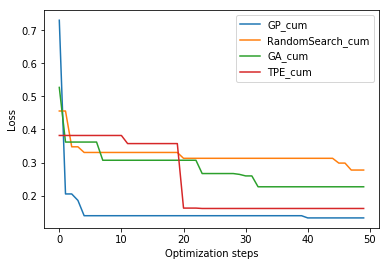

liblinear
(42, 10, 50)
liblinear
(42, 10, 50)
liblinear
(42, 10, 50)
liblinear
(42, 10, 50)


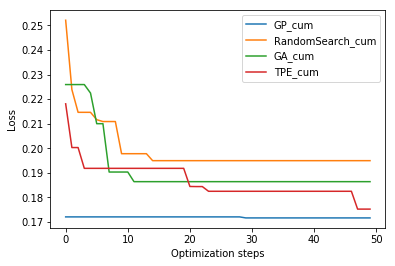

random_forest
(42, 10, 50)
random_forest
(42, 10, 50)
random_forest
(42, 10, 50)
random_forest
(42, 10, 50)


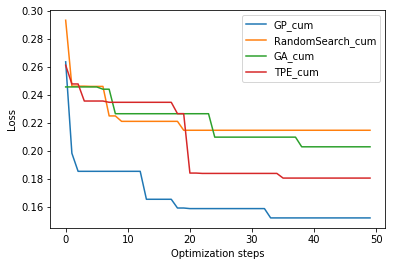

In [7]:
dataset_idx = 4
for classifier in np_results[list(np_results.keys())[0]]:
    for optimizer in np_results:
        print(classifier)
        print(np_results[optimizer][classifier].shape)
        value_per_timestep = -np.average(np_results[optimizer][classifier][dataset_idx], axis=(0))
        
        cumulative_min_data = [min(value_per_timestep[0:i+1]) for i in range(len(value_per_timestep))]
        #print(value_per_timestep.shape)
        plt.plot(cumulative_min_data, label=optimizer + "_cum")
        #plt.plot(value_per_timestep, label=optimizer)
    plt.xlabel("Optimization steps")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')
    plt.show()